In [31]:
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
import apoNN.src.utils as apoUtils
import torch
import matplotlib.pyplot as plt
import sklearn
import apogee.tools.path as apogee_path

apogee_path.change_dr(16)

# Fully unsupervised chemical tagging

**dataset: APOGEE -** large dataset of high-resolution, high signal-to-noise IR spectra.

**open cluster:** stars born from the same molecular cloud. Open-cluster are chemically-homogenous as the chemical composition of the molecular cloud is locked-in.

**chemical tagging:** Idea of identifying chemically identical stars based on chemical composition

In [19]:
dataset=  AspcapDataset(filename="aspcap_occamlike",tensor_type=torch.FloatTensor,recenter=True)
allStar =  apoUtils.load("allStar_occamlike")


What do APOGEE stars look like

Text(0.5, 0, 'wavelength-ish')

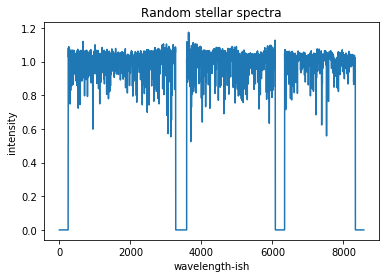

In [20]:
plt.plot(dataset.dataset["aspcap_interpolated"][0])
plt.title("Random stellar spectra")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")

We can take closer look.

(1000, 1500)

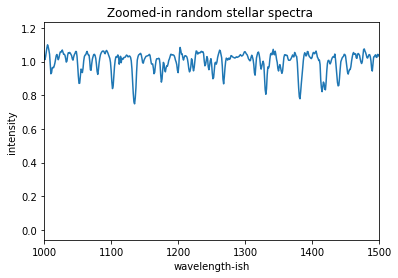

In [21]:
plt.plot(dataset.dataset["aspcap_interpolated"][0])
plt.title("Zoomed-in random stellar spectra ")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.xlim(1000,1500)

Spectra are very complicated, contain lots of absorption lines and involve non-LTE !!! Accurately modelling requires really well calibrated physics, beyond what we have, and thus extracting all chemical information is hard.

(0.8, 1.2)

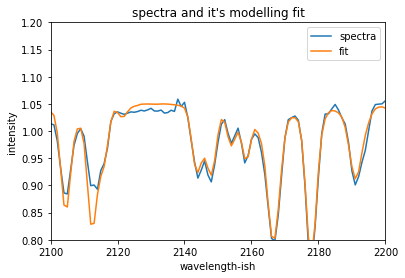

In [32]:
dataset.allStar = allStar
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=1)[0],label="spectra")
plt.plot(dataset.dataset["aspcap_interpolated"][0],label="spectra")
plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=3)[0],label="fit")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.legend()
plt.title("spectra and it's modelling fit")
plt.xlim(2100,2200)
plt.ylim(0.8,1.2)


### How to find chemically identical stars without any stellar models?

# Step 1: Obtain a lower dimensional representation of spectra

**Solution**: Principal component analysis


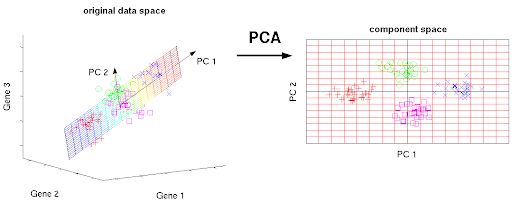

### Apply this to the spectra

In [33]:
compressor = sklearn.decomposition.PCA(n_components=20,whiten=False)#z.raw.shape[1],whiten=True)
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(2100, 2200)

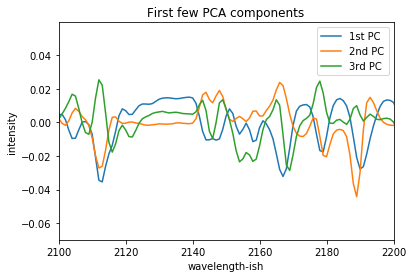

In [34]:
plt.plot(compressor.components_[0],label="1st PC")
plt.plot(compressor.components_[1],label="2nd PC")
plt.plot(compressor.components_[2],label="3rd PC")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.title("First few PCA components")
plt.legend()
plt.xlim(2100,2200)

NameError: name 'reconstructed_dataset' is not defined

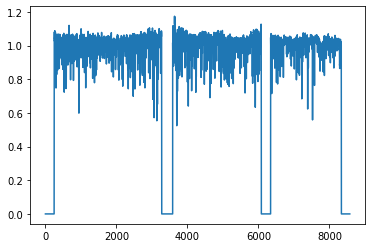

In [35]:
dataset.allStar = allStar
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=1)[0],label="spectra")
plt.plot(dataset.dataset["aspcap_interpolated"][0],label="spectra")
plt.plot(reconstructed_dataset[0],label="reconstructed")
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(5),ext=3)[0],label="fit")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.legend()
plt.title("spectra and it's PCA fit")
plt.xlim(2100,2200)
plt.ylim(0.8,1.2)


The fit using PCA is quite good, even with only **20** components it's noticeably better then the physical fit!!!

**But how to get the information out of this spectra ??**

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))
    plt.xlabel(considered_parameters[i])
    plt.ylabel(f"{considered_parameters[i]} pred")

    plt.legend()
    plt.show()

#### We see that, after applying PCA, we obtained a lower-dimensional latent representation of stellar spectra in which  each stellar parameter is well represented by a linear vector, ie, directions in our latent space match well with stellar parameters.

How can we exploit this, an identify chemically similar stars without any supervision whatsoever?

Answer:
1. Whiten our PCA representation using the full dataset of stars. This is a rescaling of our data that makes it such that our latent/PCA data looks like a unit gaussian

2. Then take an open-cluster dataset (containing one open-cluster or multiple recentered open-clusters) and apply (again) PCA on the latents of this dataset. Because, after whitening, the variance of the full dataset after projection along any direction in the latent space should be 1, the variances along a direction in our only open-cluster dataset basically corresponds to the ratio this direction varies within the full stellar dataset vs within an open custer. The lowest PC components (ie lowest variance directions) thus correspond exactly to those factors which vary much less between stars in an open-cluster than between random stars. Exactly what we want.

3. We can then measure chemical similarity between stars by measuring scaled latent space distances, where dimensions are scaled according to how small their variance is in an open clusters relative to the full stellar population.

### But does this work???

We plot the positions in the lowest PCA components of stars in open-clusters.

In [ ]:
i=14
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(v[i],density=True,alpha=0.5,label="background population")
    plt.hist(v_occam[i,clust_idxs],density=True,alpha=0.5,label="an open cluster")
    plt.ylim(0,3)
    plt.title(f"random cluster projected on dim:{i}")
    plt.xlabel(f"value")
    plt.ylabel(f"number count")
    plt.legend()
    plt.show()

In [ ]:
i=13
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(v[i],density=True,alpha=0.5,label="background population")
    plt.hist(v_occam[i,clust_idxs],density=True,alpha=0.5,label="an open cluster")
    plt.ylim(0,3)
    plt.title(f"random cluster projected on dim:{i}")
    plt.xlabel(f"value")
    plt.ylabel(f"number count")
    plt.legend()
    plt.show()

### Caveats:

- I'm only using 190 stars in open clusters. So I am limited in how many dimensions of my PCA I can keep without overfitting. I need to play around and actually ascertain that I'm not overfitting in the shown examples. (This will probably involve some form of bootstrapping). I'm confident-ish that overfitting isn't too large of an issue in the shown images.

- I've been a little bit less restrictive on my dataset cuts for my open-cluster stars (because there are so few of them). I need to really make sure that my cuts are not introducing differences in the factors of variation between both datasets which are not in the raw data (that the method could be leveraging when it shouldn't).

- The hope is that with more open-clusters discovered by GAIA, and targetted by APOGEE, we can afford to run the PCA on larger-dimensional latent spaces and improve our methods results even further.



### Aside on overfitting

If we have an n-dimensional latent. Then we are estimating a covariance matrix containing $n^2$ numbers. Each star latent contains n numbers so we need at the bare-minimum n stars to estimate the covariance matrix. However real data is messy and you need a fair few more stars. The number of high-quality open cluster stars is the limit of our method.